In [1]:
import lineapy

# Data Preprocessing Pipeline

In this example, we are creating a data preprocessing pipeline on tabular data containing features for house sales price prediction. A detailed description of the dataset can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

In [2]:
import pandas as pd
training_data = pd.read_csv("data/ames_train_cleaned.csv")

In [3]:
training_data.head(10)

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,6,2010,WD,Normal,205300,2.5
6,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,NaN,NaN,NaN,0,1,2010,WD,Normal,201400,2.0
7,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,3,2010,WD,Normal,246500,3.0
8,12,527165230,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,...,NaN,GdPrv,Shed,500,3,2010,WD,Normal,174900,3.0
9,13,527166040,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,170300,2.5


In [4]:
training_data.shape

(1998, 83)

## Remove columns with > 80% values missing

In [5]:
columns_to_drop = training_data.columns[training_data.isnull().sum() / training_data.shape[0] > .8]
columns_to_drop

Index(['Alley', 'Pool_QC', 'Fence', 'Misc_Feature'], dtype='object')

In [6]:
training_data = training_data.drop(columns_to_drop, axis=1)
training_data.shape

(1998, 79)

## Feature Group 1: Ratios of Square Footage Features

We start by plotting the relationship between different square footage features

In [8]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

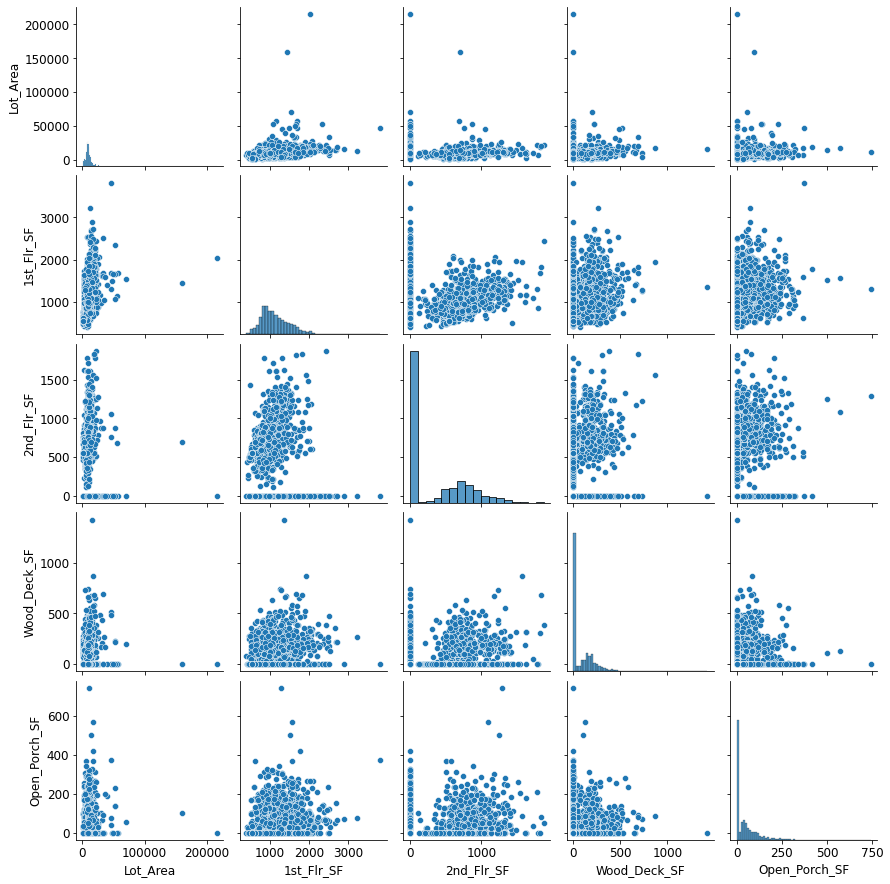

In [10]:
sf_features = ['Lot_Area', '1st_Flr_SF', '2nd_Flr_SF', 'Wood_Deck_SF', 'Open_Porch_SF']
sns.pairplot(training_data[sf_features])

From the chart above, we have identified the following relationships as features to be inserted into the training data,

- Lot_Area : 1st_Flr_SF
- 1st_Flr_SF : 2nd_Flr_SF
- Wood_Deck_SF : 2nd_Flr_SF

In addition, we will remove `1st_Flr_SF` and `2nd_Flr_SF` to avoid issues associated with correlated features.

In [11]:
training_data['LA_v_1st'] = training_data['Lot_Area'] / training_data['1st_Flr_SF']
training_data['1st_v_2nd'] = training_data['1st_Flr_SF'] / training_data['2nd_Flr_SF']
training_data['wd_v_2nd'] = training_data['Wood_Deck_SF'] / training_data['2nd_Flr_SF']
training_data = training_data.drop(['1st_Flr_SF', '2nd_Flr_SF'], axis=1)

## "Basement_Value" feature

The "Basement_Value" feature involves combining all the individual basement features to create a categorical feature with the values "high" and "low".

First, let's find all the features related to basements.

In [44]:
training_data.columns

Index(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area',
       'Street', 'Lot_Shape', 'Land_Contour', 'Utilities', 'Lot_Config',
       'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
       'House_Style', 'Overall_Qual', 'Overall_Cond', 'Year_Built',
       'Year_Remod/Add', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
       'Exterior_2nd', 'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual',
       'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC', 'Central_Air',
       'Electrical', 'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',
       'Garage_Finish', 'Garage_Cars', 'Garage_Are

In [45]:
basement_features = [x for x in training_data.columns if 'bsmt' in x.lower()]
basement_features

['Bsmt_Qual',
 'Bsmt_Cond',
 'Bsmt_Exposure',
 'BsmtFin_Type_1',
 'BsmtFin_SF_1',
 'BsmtFin_Type_2',
 'BsmtFin_SF_2',
 'Bsmt_Unf_SF',
 'Total_Bsmt_SF',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath']

In [46]:
training_data[basement_features]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Bsmt_Full_Bath,Bsmt_Half_Bath
0,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,1.0,0.0
1,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,0.0,0.0
2,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,0.0,0.0
3,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,1.0,0.0
4,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1993,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,1.0,0.0
1994,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,1.0,0.0
1995,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,1.0,0.0
1996,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,0.0,1.0


In [54]:
basement_numeric = ['BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF']
basement_categorical = ['Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1']

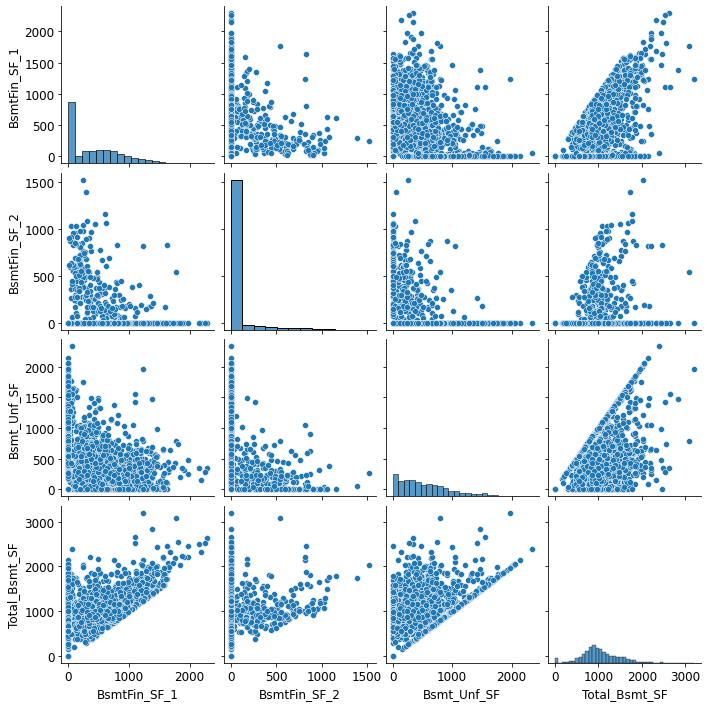

In [55]:
sns.pairplot(training_data[basement_numeric])

array([[<AxesSubplot:title={'center':'Bsmt_Full_Bath'}>,
        <AxesSubplot:title={'center':'Bsmt_Half_Bath'}>]], dtype=object)

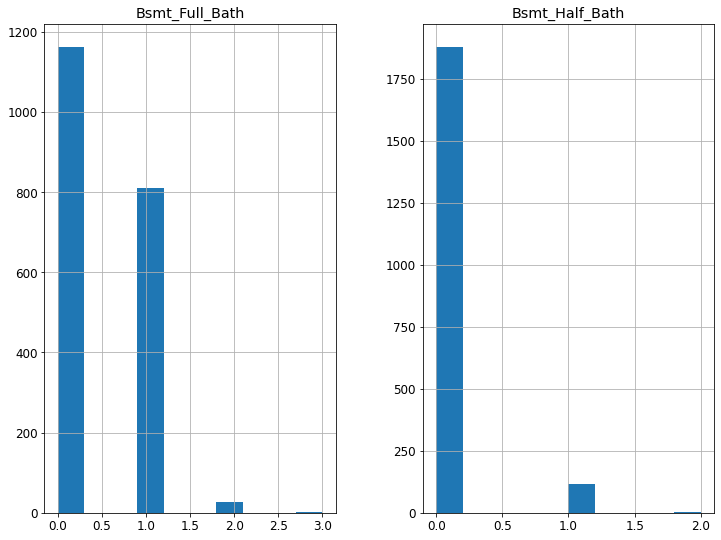

In [56]:
training_data[basement_categorical].hist()

Number of records removed: 19


In [16]:
lineapy.visualize()

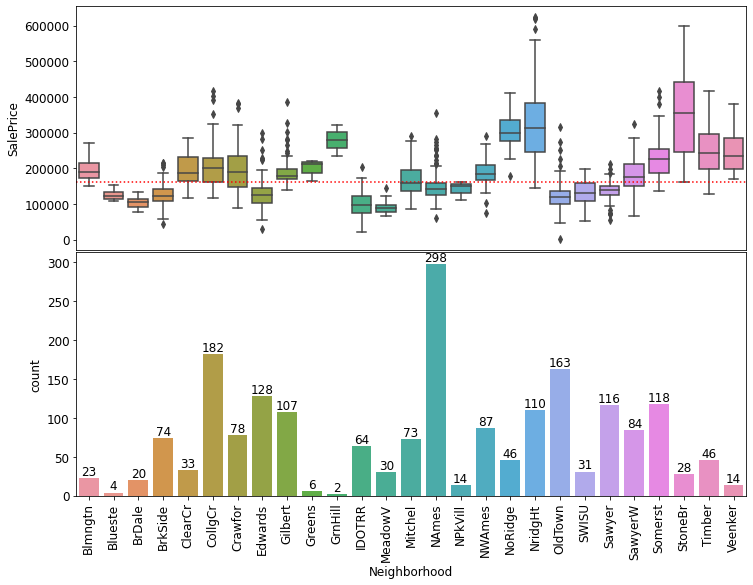

In [17]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=cleaned_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=cleaned_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=cleaned_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

I verify that Neighborhood is a very promising way to go forward.

However, in order to be able to also use linear models, I must map these neighborhoods back into numeric values (one hot encoding).

In [18]:
from pandas.api.types import CategoricalDtype

from sklearn.feature_extraction import DictVectorizer

vec_enc = DictVectorizer()
vec_enc.fit(cleaned_data[['Neighborhood']].to_dict(orient='records'))
Neighborhood_data = vec_enc.transform(cleaned_data[['Neighborhood']].to_dict(orient='records')).toarray()
Neighborhood_cats = vec_enc.get_feature_names()
Neighborhood = pd.DataFrame(Neighborhood_data, columns=Neighborhood_cats)
cleaned_data = pd.concat([cleaned_data, Neighborhood], axis=1)
cleaned_data = cleaned_data.drop(columns=Neighborhood_cats[0])

In sum, the columns that I should focus on is:

- Gr_Liv_Area
- Garage_Area
- regex='Neightborhood'

In [19]:
!mkdir -p outputs
cleaned_data.filter(
    regex="Neighborhood=.|Gr_Liv_Area|Garage_Area|SalePrice"
).to_csv("outputs/cleaned_data_housing.csv", index=False)

## Task 1: Pipeline

I want to re-run this when I have new data---i.e. when `ames_train_cleaned.csv` updates. However, I realize that I have to go to the `Exploration_without_Linea.ipynb` file to extract the process. Try to lift it manually into a airflow job.

In [21]:
# NBVAL_SKIP
# clear airflow dags to demonstrate that we are creating these dags
!rm /tmp/airflow_home/dags/*.py

rm: cannot remove '/tmp/airflow_home/dags/*.py': No such file or directory


In [22]:
artifact = lineapy.save(lineapy.file_system, "cleaned_data_housing")

[22:52:47] ERROR    Artifact could not be saved.                   tracer.py:157


In [23]:
# NBVAL_SKIP
artifact.visualize()

KeyError: 'f21d87a3-baf1-4002-855f-4396f15f67a8'

In [23]:
# NBVAL_SKIP
!rm outputs/cleaned_data_housing.csv

In [24]:
artifact.to_airflow();

KeyError: 'f21d87a3-baf1-4002-855f-4396f15f67a8'

In [25]:
print(artifact.code)

import pandas as pd
training_data = pd.read_csv("data/ames_train_cleaned.csv")
cleaned_data = training_data.drop(['Pool_QC', 'Misc_Feature'], axis=1)
cleaned_data = cleaned_data[cleaned_data['Gr_Liv_Area']  < 3000]
cleaned_data = cleaned_data[cleaned_data['Garage_Area']  < 1250]
from sklearn.feature_extraction import DictVectorizer
vec_enc = DictVectorizer()
vec_enc.fit(cleaned_data[['Neighborhood']].to_dict(orient='records'))
Neighborhood_data = vec_enc.transform(cleaned_data[['Neighborhood']].to_dict(orient='records')).toarray()
Neighborhood_cats = vec_enc.get_feature_names()
Neighborhood = pd.DataFrame(Neighborhood_data, columns=Neighborhood_cats)
cleaned_data = pd.concat([cleaned_data, Neighborhood], axis=1)
cleaned_data = cleaned_data.drop(columns=Neighborhood_cats[0])
cleaned_data.filter(
    regex="Neighborhood=.|Gr_Liv_Area|Garage_Area|SalePrice"
).to_csv("outputs/cleaned_data_housing.csv", index=False)



If we wait for airflow to run, we can see that the CSV is now re-computed:

In [26]:
# NBVAL_IGNORE_OUTPUT
!head -n 10 outputs/cleaned_data_housing.csv

head: cannot open 'outputs/cleaned_data_housing.csv' for reading: No such file or directory
